In [1]:
# Import 
import os
import time
import json
import datetime
import numpy as np
import pandas as pd

from IPython.display import display

from pathlib import Path
from tyssue import config
from tyssue import Sheet, SheetGeometry as geom
from tyssue.io import hdf5
from tyssue.io.hdf5 import load_datasets
from tyssue.dynamics import SheetModel as basemodel
from tyssue.dynamics.apoptosis_model import SheetApoptosisModel as model
from tyssue.solvers.sheet_vertex_solver import Solver as solver
from tyssue.draw import sheet_view
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.draw.ipv_draw import sheet_view as ipv_draw 

from tyssue.behaviors.event_manager import EventManager
from tyssue.behaviors.sheet.apoptosis_events import apoptosis

import matplotlib.pyplot as plt
%matplotlib inline

try:
    import seaborn as sns
except ImportError:
    print('Seaborn not found')


In [2]:
SIM_DIR = Path('/home/admin-suz/Documents/Simulations/')
today = datetime.date.today()

sim_save_dir = SIM_DIR/f'{today.isoformat()}_twofolds'

try:
    os.mkdir(sim_save_dir)
except FileExistsError:
    pass

In [3]:
# Create tissue tissue 

def load_before_apopto(anchor_tension=0, fixed_boundaries=True):

    h5store = '../../tyssue/doc/examples/before_apoptosis.hf5'
    #h5store = '../data/hf5/small_hexagonal.hf5'

    datasets = load_datasets(h5store,
                             data_names=['face', 'vert', 'edge'])
    specs = config.geometry.cylindrical_sheet()
    sheet = Sheet('fold', datasets, specs)
    sheet.sanitize()
    geom.update_all(sheet)

    sheet.edge_df['opposite'] = sheet.get_opposite()

    sheet.vert_df.is_active = 1
    if anchor_tension > 0:
        create_anchors(sheet)
        nondim_specs = config.dynamics.quasistatic_sheet_spec_anchors()
        nondim_specs['edge']['anchor_tension'] = anchor_tension
    else:
        nondim_specs = config.dynamics.quasistatic_sheet_spec()
        if fixed_boundaries:
            free_edges = sheet.edge_df[sheet.edge_df.opposite==-1].index
            free_srces = set(sheet.edge_df.loc[free_edges, 'srce'])
            sheet.vert_df.loc[free_srces, 'is_active'] = 0
            sheet.edge_df.loc[free_edges, 'is_active'] = 0
            free_faces = set(sheet.edge_df.loc[free_edges, 'face'])
            sheet.face_df.loc[free_faces, 'is_alive'] = 0

    dim_model_specs = model.dimensionalize(nondim_specs)
    sheet.update_specs(dim_model_specs, reset=True)
    # isotropic_relax(sheet, nondim_specs)
    # sheet.vert_df.loc[dead_src, 'is_active'] = 0
    return sheet, nondim_specs

sheet, nondim_specs = load_before_apopto(0, fixed_boundaries=True)

geom.update_all(sheet)



Reseting column contractility of the face dataset with new specs
Reseting column vol_elasticity of the face dataset with new specs
Reseting column prefered_height of the face dataset with new specs
Reseting column prefered_area of the face dataset with new specs
Reseting column prefered_vol of the face dataset with new specs
Reseting column radial_tension of the vert dataset with new specs
Reseting column is_active of the vert dataset with new specs
Reseting column line_tension of the edge dataset with new specs
Reseting column is_active of the edge dataset with new specs


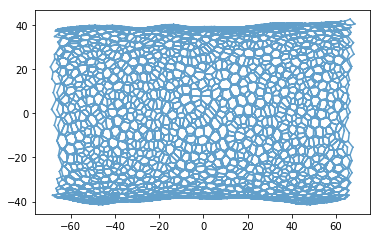

In [4]:
fig, ax = quick_edge_draw(sheet, ['z', 'x'],
                              alpha=0.7)




In [5]:
import ipyvolume as ipv
ipv.clear()
# code couleur profondeur du tissu
fig, mesh = sheet_view(sheet, mode="3D", coords=['z', 'x', 'y'],
                   edge={'color':sheet.vert_df.y*(sheet.vert_df.y>0),
                         'colormap':'viridis'})
fig

Figure(camera_center=[0.0, 0.0, 0.0], height=500, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], matrix_world=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], meshes=[Mesh(color=array([[0.267004, 0.004874, 0.329415],
       [0.282656, 0.100196, 0.42216 ],
       [0.273006, 0.20452 , 0.501721],
       ...,
       [0.267004, 0.004874, 0.329415],
       [0.267004, 0.004874, 0.329415],
       [0.267004, 0.004874, 0.329415]]), lines=array([[   0,    1],
       [   3,    0],
       [   1,    6],
       ...,
       [3389, 1084],
       [3390, 3389],
       [1031, 3390]], dtype=uint32), texture=None, x=array([-66.53937518, -65.59878595, -66.94458322, ..., -49.84531275,
        -4.84161791,  -3.8055191 ]), y=array([ 37.75063138,  38.17982688,  37.18820417, ...,  17.42841231,
       -34.51481511, -36.01018929]), z=array([ -0.54787444,   2.82079122,   6.15789302, ..., -36.88244979,
       -17.30611759, -13.54469249]))], style={'axes': {'visible': False, 'label': {'color': 'white'}, 'ticklabel': {'color': 'white'}, 'color': 'white'}, 'box': {'visible': False}, 'background-color': 'black'}, tf=None, width=400, xlim=[-76.10494368819289, 75.40934069105342], ylim=[-76.10494368819289, 75.40934069105342], zlim=[-76.10494368819289, 75.40934069105342])

In [6]:
sheet.vert_df.loc[sheet.vert_df[sheet.vert_df.z>59].index,'is_active'] = 0
sheet.vert_df.loc[sheet.vert_df[sheet.vert_df.z<-59].index,'is_active'] = 0

In [7]:
sheet.face_df.columns

Index(['z', 'area', 'is_alive', 'perimeter', 'x', 'y', 'old_idx', 'num_sides',
       'vol', 'prefered_area', 'contractility', 'vol_elasticity',
       'prefered_height', 'prefered_vol', 'basal_shift', 'height', 'rho'],
      dtype='object')

In [8]:
sheet.edge_df.columns

Index(['srce', 'trgt', 'face', 'length', 'dy', 'dz', 'ny', 'nx', 'dx', 'nz',
       'sub_area', 'sub_vol', 'line_tension', 'sx', 'sy', 'sz', 'tx', 'ty',
       'tz', 'fx', 'fy', 'fz', 'is_active', 'is_valid', 'opposite', 'ux', 'uy',
       'uz'],
      dtype='object')

In [9]:
sheet.vert_df.columns

Index(['is_active', 'z', 'x', 'y', 'old_idx', 'basal_shift', 'rho', 'height',
       'radial_tension'],
      dtype='object')

In [10]:
def apopto_pdf(zed, theta, z0=0.,
               width_apopto=1.7, amp=0.7):
    p = (np.exp(-(zed - z0)**2 / width_apopto**2) *
         (1 - amp*(np.cos(theta/2)**2)))
    return p

def get_apopto_cells(sheet, z):

    np.random.seed(40)
    sheet.face_df['theta'] = np.arctan2(sheet.face_df['x'],
                                        sheet.face_df['y'])
    
    p_apopto = apopto_pdf(sheet.face_df['z'], sheet.face_df['theta'], z)
    rand_field = np.random.random(sheet.face_df.shape[0])
    apopto_cells = p_apopto[p_apopto>rand_field].index
    apopto_cells = np.array([c for c in sheet.face_df.loc[apopto_cells].sort_values('x').index
                             if sheet.face_df.loc[c, 'is_alive']])
    return apopto_cells

number of apoptotic cells: 20
id apoptotic cells :  [ 440  386  955 1143  493 1104  304 1270  574  601 1024 1130 1289  682
  736   88  763  790 1003   35]


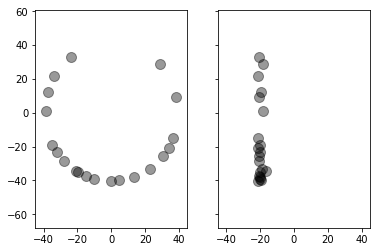

In [11]:
first_apopto_cells = get_apopto_cells(sheet, -20)
print('number of apoptotic cells: {}'.format(first_apopto_cells.size))

fig, (ax0, ax1) = plt.subplots(1, 2, sharex=True, sharey=True)
ax0.scatter(sheet.face_df.loc[first_apopto_cells, 'x'], 
            sheet.face_df.loc[first_apopto_cells, 'y'], c='k',
            s=100, alpha=0.4)
ax0.set_aspect('equal')


ax1.scatter(sheet.face_df.loc[first_apopto_cells, 'z'], 
            sheet.face_df.loc[first_apopto_cells, 'y'], c='k',
            s=100, alpha=0.4)
ax1.set_aspect('equal')
ax1.set_xlim(-45, 45);
print ('id apoptotic cells : ', first_apopto_cells)

number of apoptotic cells: 24
id apoptotic cells :  [ 473  366 1207  995  528  582  609 1157  663  204 1349  717 1487 1348
  997  744  123 1523  798 1585  825  895  851  852]


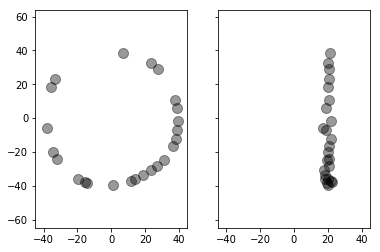

In [12]:
second_apopto_cells = get_apopto_cells(sheet, 20)
print('number of apoptotic cells: {}'.format(second_apopto_cells.size))

fig, (ax0, ax1) = plt.subplots(1, 2, sharex=True, sharey=True)
ax0.scatter(sheet.face_df.loc[second_apopto_cells, 'x'], 
            sheet.face_df.loc[second_apopto_cells, 'y'], c='k',
            s=100, alpha=0.4)
ax0.set_aspect('equal')


ax1.scatter(sheet.face_df.loc[second_apopto_cells, 'z'], 
            sheet.face_df.loc[second_apopto_cells, 'y'], c='k',
            s=100, alpha=0.4)
ax1.set_aspect('equal')
ax1.set_xlim(-45, 45);
print ('id apoptotic cells : ', second_apopto_cells)

In [13]:
def apoptosis_time_table(sheet,
                         apoptotic_cell,
                         start_t=0):

    settings = {
        'shrink_steps': 10,
        'rad_tension': 2.0,
        'contractile_increase': 2.0,
        'contract_span': 3
        }
    shrink_steps = settings['shrink_steps']
    rad_tension = settings['rad_tension']
    contractile_increase = settings['contractile_increase']
    contract_span = settings['contract_span']

    apoptotic_edges = sheet.edge_df[sheet.edge_df['face'] == apoptotic_cell]

    n_sides = apoptotic_edges.shape[0]
    # Number of type 1 transitions to solve the rosette
    n_type1 = n_sides - 3
    end_shrink = start_t + shrink_steps
    end_t = start_t + shrink_steps + n_type1

    times = range(start_t, end_t+1)
    shrink_times = range(start_t, end_shrink)

    cell_time_idx = pd.MultiIndex.from_tuples(
        [(t, apoptotic_cell) for t in times],
        names=['t', 'face'])

    time_table = pd.DataFrame(index=cell_time_idx,
                              columns=['start'])

    pref_vols = np.logspace(0., -4., shrink_steps)
    time_table.loc[start_t, 'start'] = 1

    


    return times, time_table.sort_index()

def get_time_table(sheet, apopto_cells):

    time_tables = []
    for strat_t, cell in enumerate(apopto_cells):

        times, time_table = apoptosis_time_table(sheet, cell, start_t=strat_t)
        time_tables.append(time_table)
    time_table = pd.concat(time_tables).sort_index()
    times = time_table.index.levels[0]
    return times, time_table


In [14]:
first_times, first_time_table = get_time_table(sheet, first_apopto_cells)

In [15]:
second_times, second_time_table = get_time_table(sheet, second_apopto_cells)

In [16]:
def invert_dico(dico):
    new_dico={}
    for (face, time) in dico.items():
        new_dico[time]=[face]
    return new_dico


# Get moment where apoptotic cell need to start. 
first_start_apoptosis={}
for t in first_time_table.itertuples():
    if t.Index[1] not in first_start_apoptosis:
        first_start_apoptosis[t.Index[1]]=t.Index[0]
first_start_apoptosis=invert_dico(first_start_apoptosis)

second_start_apoptosis={}
for t in second_time_table.itertuples():
    if t.Index[1] not in second_start_apoptosis:
        second_start_apoptosis[t.Index[1]]=t.Index[0]+11
second_start_apoptosis=invert_dico(second_start_apoptosis)

In [17]:
def combine_two_dictionnary(dico1, dico2):
    for (time, face) in dico2.items():
        if time in dico1 : 
            dico1[time].extend(face)
        else :
            dico1[time]= face 
    return dico1
            
start_apoptosis = combine_two_dictionnary(first_start_apoptosis, second_start_apoptosis)
start_apoptosis

{0: [440],
 1: [386],
 2: [955],
 3: [1143],
 4: [493],
 5: [1104],
 6: [304],
 7: [1270],
 8: [574],
 9: [601],
 10: [1024],
 11: [1130, 473],
 12: [1289, 366],
 13: [682, 1207],
 14: [736, 995],
 15: [88, 528],
 16: [763, 582],
 17: [790, 609],
 18: [1003, 1157],
 19: [35, 663],
 20: [204],
 21: [1349],
 22: [717],
 23: [1487],
 24: [1348],
 25: [997],
 26: [744],
 27: [123],
 28: [1523],
 29: [798],
 30: [1585],
 31: [825],
 32: [895],
 33: [851],
 34: [852]}

In [18]:
solver_kw = {'minimize': {'method': 'L-BFGS-B',
                              'options': {'ftol': 1e-8,
                                          'gtol': 1e-8}}}
res = solver.find_energy_min(sheet, geom, model, **solver_kw)
print(res['success'])

True


In [19]:
def run_sim(sim_save_dir, sheet, radial_tension, iteration=0):
    
    dirname = '{}_radial_tension_{}'.format(
        radial_tension, iteration)
    dirname = os.path.join(sim_save_dir, dirname)
    
    print('starting {}'.format(dirname))
    try:
        os.mkdir(dirname)
    except IOError:
        pass

    
    apoptosis_settings = {
        "radial_tension": radial_tension,
        "shrink_rate": 1.08,
        "critical_area": 1e-2,
        "contractile_increase": 0.1,
        "contract_span": 2,
        "geom": geom,
    }
    
    
    # Add some information to the sheet and copy initial sheet
    sheet2 = sheet.copy(deep_copy=True)
    sheet2.face_df['id'] = sheet2.face_df.index.values
    sheet2.settings['apoptosis'] = apoptosis_settings
    
    #""" Initiale find minimal energy
    # To be sure we are at the equilibrium
    solver_kw = {'minimize': {'method': 'L-BFGS-B',
                              'options': {'ftol': 1e-8,
                                          'gtol': 1e-8}}}
    #res = solver.find_energy_min(sheet2, geom, model, **solver_kw)

    sheet2 = apoptosis_process(dirname, solver, solver_kw, sheet2, geom, model,
                     radial_tension)

    print('{} done'.format(dirname))
    print('~~~~~~~~~~~~~~~~~~~~~\n')

In [20]:
def apoptosis_process(dirname, solver, solver_kw, sheet, geom, model, radial_tension):
    
    # Initiate manager
    manager = EventManager('face')
    sheet.face_df['enter_in_process'] = 0
    
    t = 0
    stop = 200
    sheet.face_df['contract_rate'] = 0
    
      
        
    # Run simulation
    while manager.current and t < stop:
        
        # Add face in apoptosis according to the 
        # spatio-temporal patterning define previously
        if t in start_apoptosis:
            for f in start_apoptosis[t]:
                apopto_kwargs = sheet.settings['apoptosis'].copy()
                apopto_kwargs.update(
                    {
                        'face_id': f
                    }
                )
                manager.append(apoptosis, **apopto_kwargs)
        
        
        manager.execute(sheet)
        
        res = solver.find_energy_min(sheet, geom, model, **solver_kw)

        # add noise on vertex position to avoid local minimal.
        sheet.vert_df[
            ['x', 'y']] += np.random.normal(scale=1e-3, size=(sheet.Nv, 2))
        geom.update_all(sheet)

        # Save result in each time step.
        figname = os.path.join(
            dirname, 'invagination_{:04d}.png'.format(t))
        hdfname = figname[:-3] + 'hf5'
        hdf5.save_datasets(hdfname, sheet)

        manager.update()
        t += 1

    return sheet


In [21]:
# Sequential Execution

from datetime import datetime

global_start=datetime.now()
print ("start : " + str(global_start))

# Variable non utilisée...
radial_tension = [2,5,10,15,20,25,30 ]

for rd in radial_tension:
    for iteration in range (0, 1):
        run_sim(sim_save_dir, sheet, rd, iteration)
        
        
        
global_end = datetime.now()
print ("end : " + str(global_end))
print ('Duree totale d execution : \n\t\t')
print (global_end-global_start)

start : 2019-05-17 16:57:10.947552
starting /home/admin-suz/Documents/Simulations/2019-05-17_twofolds/2_radial_tension_0


/home/admin-suz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->['opposite']]



/home/admin-suz/Documents/Simulations/2019-05-17_twofolds/2_radial_tension_0 done
~~~~~~~~~~~~~~~~~~~~~

starting /home/admin-suz/Documents/Simulations/2019-05-17_twofolds/5_radial_tension_0
/home/admin-suz/Documents/Simulations/2019-05-17_twofolds/5_radial_tension_0 done
~~~~~~~~~~~~~~~~~~~~~

starting /home/admin-suz/Documents/Simulations/2019-05-17_twofolds/10_radial_tension_0
/home/admin-suz/Documents/Simulations/2019-05-17_twofolds/10_radial_tension_0 done
~~~~~~~~~~~~~~~~~~~~~

starting /home/admin-suz/Documents/Simulations/2019-05-17_twofolds/15_radial_tension_0
/home/admin-suz/Documents/Simulations/2019-05-17_twofolds/15_radial_tension_0 done
~~~~~~~~~~~~~~~~~~~~~

starting /home/admin-suz/Documents/Simulations/2019-05-17_twofolds/20_radial_tension_0
/home/admin-suz/Documents/Simulations/2019-05-17_twofolds/20_radial_tension_0 done
~~~~~~~~~~~~~~~~~~~~~

starting /home/admin-suz/Documents/Simulations/2019-05-17_twofolds/25_radial_tension_0
/home/admin-suz/Documents/Simulations/

In [25]:
SIM_DIR = Path('/home/admin-suz/Documents/Simulations/2019-05-17_twofolds')
dirname = SIM_DIR/'10_radial_tension_0/'
from tyssue.draw import sheet_view

import ipyvolume.pylab as p3
hfs = [f  for f in os.listdir(dirname)
       if f.endswith('hf5')]
hfs.sort(key=lambda x: os.path.getctime(os.path.join(dirname, x)))

current = 'invagination_0000.hf5'
ipv.clear()
ipv.style.use('dark')


dsets = hdf5.load_datasets(os.path.join(dirname, current),
                               data_names=['vert', 'edge', 'face', 'cell'])

specs = config.geometry.cylindrical_sheet()
sheet = Sheet('ellipse', dsets, specs)

#sheet = sheet.extract_bounding_box(z_boundary=[-200,50])
def draw_specs(sheet):
    specs = {
        'edge': {
            'visible': True,
            'color': sheet.vert_df.y
        },
        'face': {
            'visible': True,
            'color': sheet.face_df.area,
            'colormap': 'Blues'
        }
    }
    return specs

ipv.clear()
ipv_fig, meshes = sheet_view(sheet, coords=list('zxy'),
                             mode='3D', **draw_specs(sheet))
ipv_fig

Figure(camera_center=[0.0, 0.0, 0.0], height=500, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], matrix_world=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], meshes=[Mesh(color=array([[0.129933, 0.559582, 0.551864],
       [0.120565, 0.596422, 0.543611],
       [0.122312, 0.633153, 0.530398],
       ...,
       [0.280894, 0.078907, 0.402329],
       [0.210503, 0.363727, 0.552206],
       [0.188923, 0.41091 , 0.556326]]), lines=array([[   0,    1],
       [   3,    0],
       [   1,    6],
       ...,
       [3389, 1084],
       [3390, 3389],
       [1031, 3390]], dtype=uint32), texture=None, x=array([-66.53937518, -65.59878595, -66.94458322, ..., -48.80915102,
        -4.71549762,  -3.52826048]), y=array([ 37.75112859,  38.18032466,  37.18692328, ...,  18.13760222,
       -36.61657157, -38.20645187]), z=array([ -0.54671114,   2.82204908,   6.15689948, ..., -38.48838985,
       -18.06329966, -13.95470967])), Mesh(color=array([[0.31620146, 0.61173395, 0.79886198],
       [0.40699731, 0.67374087, 0.8342945 ],
       [0.3666436 , 0.64618224, 0.81854671],
       ...,
       [0.3666436 , 0.64618224, 0.81854671],
       [0.3666436 , 0.64618224, 0.81854671],
       [0.3666436 , 0.64618224, 0.81854671]]), texture=None, triangles=array([[    0,  1662, 11634],
       [    0,  1663, 11635],
       [    0,  1664, 11636],
       ...,
       [ 1661, 11631, 21603],
       [ 1661, 11632, 21604],
       [ 1661, 11633, 21605]], dtype=uint32), x=array([-64.08104741, -56.42606027, -54.14947979, ...,  -2.18060325,
        -4.71549762,  -3.52826048]), y=array([ 38.29570548,  39.97554954,  40.33465976, ..., -35.33051988,
       -36.61657157, -38.20645187]), z=array([ -0.33669104,   0.85973097,  -3.51072636, ..., -20.53553051,
       -18.06329966, -13.95470967]))], style={'axes': {'visible': False, 'label': {'color': 'white'}, 'ticklabel': {'color': 'white'}, 'color': 'white'}, 'box': {'visible': False}, 'background-color': 'black'}, tf=None, width=400, xlim=[-76.10494368819289, 75.40934069105342], ylim=[-76.10494368819289, 75.40934069105342], zlim=[-76.10494368819289, 75.40934069105342])

In [29]:
SIM_DIR = Path('/home/admin-suz/Documents/Simulations/2019-05-17_twofolds')
dirname = SIM_DIR/'30_radial_tension_0/'
from tyssue.draw import sheet_view

import ipyvolume.pylab as p3
hfs = [f  for f in os.listdir(dirname)
       if f.endswith('hf5')]
hfs.sort(key=lambda x: os.path.getctime(os.path.join(dirname, x)))

current = 'invagination_0150.hf5'
ipv.clear()
ipv.style.use('dark')


dsets = hdf5.load_datasets(os.path.join(dirname, current),
                               data_names=['vert', 'edge', 'face', 'cell'])

specs = config.geometry.cylindrical_sheet()
sheet = Sheet('ellipse', dsets, specs)

#sheet = sheet.extract_bounding_box(z_boundary=[-200,50])
def draw_specs(sheet):
    specs = {
        'edge': {
            'visible': True,
            'color':sheet.vert_df.y*(sheet.vert_df.y>0),
            'colormap':'viridis'
        },
        'face': {
            'visible': True,
            'color': sheet.face_df.area,
            'colormap': 'Blues'
        }
    }
    return specs
ipv.clear()
ipv_fig, meshes = sheet_view(sheet, coords=list('zxy'),
                             mode='3D', **draw_specs(sheet))
ipv_fig

Figure(camera_center=[0.0, 0.0, 0.0], height=500, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], matrix_world=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], meshes=[Mesh(color=array([[0.267004, 0.004874, 0.329415],
       [0.282327, 0.094955, 0.417331],
       [0.276194, 0.190074, 0.493001],
       ...,
       [0.267004, 0.004874, 0.329415],
       [0.267004, 0.004874, 0.329415],
       [0.160665, 0.47854 , 0.558115]]), lines=array([[   0,    1],
       [   3,    0],
       [   1,    6],
       ...,
       [3386, 1083],
       [3387, 3386],
       [1030, 3387]], dtype=uint32), texture=None, x=array([-66.53937518, -65.59878595, -66.94458322, ...,  -4.19551891,
        -2.63881334, -22.90667506]), y=array([ 37.75211886,  38.18738165,  37.19249114, ..., -38.30480228,
       -39.43018754, -24.2986175 ]), z=array([ -0.52800833,   2.81213077,   6.12824473, ..., -14.78091156,
       -11.62173365,  17.9213393 ])), Mesh(color=array([[0.81707036, 0.88589004, 0.95078816],
       [0.82592849, 0.89179546, 0.95374087],
       [0.82592849, 0.89179546, 0.95374087],
       ...,
       [0.83183391, 0.89573241, 0.95570934],
       [0.83183391, 0.89573241, 0.95570934],
       [0.83183391, 0.89573241, 0.95570934]]), texture=None, triangles=array([[    0,  1661, 11627],
       [    0,  1662, 11628],
       [    0,  1663, 11629],
       ...,
       [ 1660, 11624, 21590],
       [ 1660, 11625, 21591],
       [ 1660, 11626, 21592]], dtype=uint32), x=array([-64.08104741, -56.62094847, -54.48549918, ...,  -1.79672514,
        -4.19551891,  -2.63881334]), y=array([ 38.29985706,  40.17055648,  40.67660519, ..., -36.71179548,
       -38.30480228, -39.43018754]), z=array([ -0.33202029,   0.98742806,  -3.34166472, ..., -18.3150191 ,
       -14.78091156, -11.62173365]))], style={'axes': {'visible': False, 'label': {'color': 'white'}, 'ticklabel': {'color': 'white'}, 'color': 'white'}, 'box': {'visible': False}, 'background-color': 'black'}, tf=None, width=400, xlim=[-76.10494368819289, 75.40934069105342], ylim=[-76.10494368819289, 75.40934069105342], zlim=[-76.10494368819289, 75.40934069105342])